In [1]:
import random
import time
import warnings
from datetime import datetime

import torch

import numpy as np
import warnings
np.warnings = warnings
import matplotlib.pyplot as plt
from tabpfn_new.scripts.differentiable_pfn_evaluation import eval_model_range
from tabpfn_new.scripts.model_builder import get_model, get_default_spec, save_model, load_model
from tabpfn_new.scripts.transformer_prediction_interface import transformer_predict, get_params_from_config, load_model_workflow

from tabpfn_new.scripts.model_configs import *

#from datasets import load_openml_list, open_cc_dids, open_cc_valid_dids
from tabpfn_new.priors.utils import plot_prior, plot_features
from tabpfn_new.priors.utils import uniform_int_sampler_f

from tabpfn_new.scripts.tabular_metrics import calculate_score_per_method, calculate_score
from tabpfn_new.scripts.tabular_evaluation import evaluate

from tabpfn_new.priors.differentiable_prior import DifferentiableHyperparameterList, draw_random_style, merge_style_with_info
from tabpfn_new.scripts import tabular_metrics
from tabpfn.notebook_utils import *

In [2]:
device = 'cpu'
base_path = '.'
max_features = 100

In [9]:
def reload_config(prior_type='forest', config_type='causal', task_type='multiclass', longer=0):
    config = get_prior_config(config_type=config_type)
    
    config['prior_type'], config['differentiable'], config['flexible'] = prior_type, False, False
    
    model_string = ''
    
    config['epochs'] = 12000
    config['recompute_attn'] = True

    config['max_num_classes'] = 10
    config['num_classes'] = uniform_int_sampler_f(2, config['max_num_classes'])
    config['balanced'] = False
    model_string = model_string + '_multiclass'
    
    model_string = model_string + '_'+datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
    
    return config, model_string

In [10]:
prior_type = 'mlp'
config, model_string = reload_config(prior_type, longer=1)

config['bptt_extra_samples'] = None

# diff
config['output_multiclass_ordered_p'] = 0.
del config['differentiable_hyperparameters']['output_multiclass_ordered_p']

config['multiclass_type'] = 'rank'
del config['differentiable_hyperparameters']['multiclass_type']

config['sampling'] = 'normal' # vielleicht schlecht?
del config['differentiable_hyperparameters']['sampling']

config['pre_sample_causes'] = True
# end diff

config['multiclass_loss_type'] = 'nono' # 'compatible'
config['normalize_to_ranking'] = False # False

config['categorical_feature_p'] = .2 # diff: .0

# turn this back on in a random search!?
config['nan_prob_no_reason'] = .0
config['nan_prob_unknown_reason'] = .0 # diff: .0
config['set_value_to_nan'] = .1 # diff: 1.

config['normalize_with_sqrt'] = False

config['new_mlp_per_example'] = True
config['prior_mlp_scale_weights_sqrt'] = True
config['batch_size_per_gp_sample'] = None

config['normalize_ignore_label_too'] = False

config['differentiable_hps_as_style'] = False
config['max_eval_pos'] = 1000

config['random_feature_rotation'] = True
config['rotate_normalized_labels'] = True

config["mix_activations"] = False # False heisst eig True

config['emsize'] = 512
config['nhead'] = config['emsize'] // 128
config['bptt'] = 1024+128
config['canonical_y_encoder'] = False

    
config['aggregate_k_gradients'] = 1
config['batch_size'] = 1*config['aggregate_k_gradients']
config['num_steps'] = 1//config['aggregate_k_gradients']
config['epochs'] = 1

config['total_available_time_in_s'] = None #60*60*22 # 22 hours for some safety...

config['train_mixed_precision'] = True
config['efficient_eval_masking'] = True

# forest params
config["min_features"] = 10
config["max_features"] = 100
config["n_samples"] = 1000
config["max_classes"] = 10
config["base_size"] = 1000
config["n_estimators"] = 1
config["min_depth"] = 1
config["max_depth"] = 25
config["categorical_x"] = False

config_sample = evaluate_hypers(config)
for key in config_sample:
    print(key, config_sample[key])

lr 0.0001381243706986394
dropout 0.0
emsize 512
batch_size 1
nlayers 12
num_features 100
nhead 4
nhid_factor 2
bptt 1152
eval_positions None
seq_len_used 50
sampling normal
epochs 1
num_steps 1
verbose False
mix_activations False
pre_sample_causes True
multiclass_type rank
nan_prob_unknown_reason_reason_prior 0.5
categorical_feature_p 0.2
nan_prob_no_reason 0.0
nan_prob_unknown_reason 0.0
nan_prob_a_reason 0.0
max_num_classes 10
num_classes <function <lambda>.<locals>.<lambda> at 0x000001ADD1C63420>
noise_type Gaussian
balanced False
normalize_to_ranking False
set_value_to_nan 0.1
normalize_by_used_features True
num_features_used {'uniform_int_sampler_f(3,max_features)': <function <lambda>.<locals>.<lambda> at 0x000001ADD1C62E80>}
num_categorical_features_sampler_a -1.0
differentiable_hyperparameters {'prior_bag_exp_weights_1': {'distribution': 'uniform', 'min': 2.0, 'max': 10.0}, 'num_layers': {'distribution': 'meta_gamma', 'max_alpha': 2, 'max_scale': 3, 'round': True, 'lower_bound':

In [11]:
model = get_model(config_sample, device, should_train=True, verbose=0)

Using style prior: False
Using cpu:0 device
Using a Transformer with 25.82 M parameters


KeyError: 'prior_mlp_activations'

Using style prior: True
Using cpu:0 device
Using a Transformer with 25.82 M parameters


C:\Users\lenna\anaconda3\envs\master\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


torch.Size([1000, 4, 100]) torch.Size([1000, 4])
Hparams dict_keys(['prior_bag_exp_weights_1', 'num_layers_alpha', 'num_layers_scale', 'prior_mlp_hidden_dim_alpha', 'prior_mlp_hidden_dim_scale', 'prior_mlp_dropout_prob_b', 'prior_mlp_dropout_prob_k', 'noise_std_log_mean', 'noise_std_log_std', 'init_std_log_mean', 'init_std_log_std', 'num_causes_alpha', 'num_causes_scale', 'is_causal_choice_1_weight', 'pre_sample_weights_choice_1_weight', 'y_is_effect_choice_1_weight', 'prior_mlp_activations_choice_1_weight', 'prior_mlp_activations_choice_2_weight', 'block_wise_dropout_choice_1_weight', 'sort_features_choice_1_weight', 'in_clique_choice_1_weight', 'outputscale_log_mean', 'outputscale_log_std', 'lengthscale_log_mean', 'lengthscale_log_std', 'noise_choice_1_weight', 'noise_choice_2_weight'])


ValueError: The following variable cannot be assigned with wide-form data: `hue`

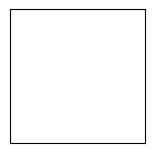

In [6]:
config_sample['batch_size'] = 4
model = get_model(config_sample, device, should_train=False, verbose=2) # , state_dict=model[2].state_dict()
(hp_embedding, data, _), targets, single_eval_pos = next(iter(model[3]))

#from utils import normalize_data
fig = plt.figure(figsize=(8, 8))
N = 100
plot_features(data[0:N, 0, 0:4], targets[0:N, 0], fig=fig)

d = np.concatenate([data[:, 0, :].T, np.expand_dims(targets[:, 0], -1).T])
d[np.isnan(d)] = 0
c = np.corrcoef(d)
plt.matshow(np.abs(c), vmin=0, vmax=1)
plt.show()